# Example running experiments on XPC

This notebooks illustrates how to use the analysis functions of XPC to conduct experiments on various parameters. These experiments are most relevant when having to access to true parts to compare to.

### Imports

In [1]:
import os
os.chdir("..") #call only once

In [2]:
from xpc.utils import series
from xpc.utils import data
from xpc.utils import models
from xpc.shapley import analysis
from xpc.shapley import preprocess

import numpy as np
from time import perf_counter

import importlib #to reload packages, call importlib.reload(analysis) or importlib.reload(analysis.explainers)

## Loading data and model

### Data

In [3]:
#train and test
df_train = data.read_dataset("df_train","datasets/data_smach")
df_test = data.read_dataset("df_test","datasets/data_smach")
background = df_train.drop(columns=["Load", "PC", "HPC"])
background_y = df_train.Load
background_contribs = df_train[["PC","HPC"]].rename(columns={"PC":"C","HPC":"NC"})
X = df_test.drop(columns=["Load", "PC", "HPC"])
y = df_test.Load
true_contribs = df_test[["PC","HPC"]].rename(columns={"PC":"C","HPC":"NC"})
print("Train shape: ", df_train.shape)
print("Test shape: ", df_test.shape)

Train shape:  (70128, 17)
Test shape:  (17520, 17)


In [4]:
#feature mappings
col_mapping = {
    "C":["temp", "temp_liss_fort","temp_liss_faible","tempMax","tempMin","sun","wind"],
    "NC":["Instant", "JourSemaine","Weekend","Posan","JourFerie","offset","DayType"],
}

features_map = {
    "temp":"continuous",
    "wind":"continuous",
    "sun":"continuous",
    "temp_liss_fort":"continuous",
    "temp_liss_faible":"continuous",
    "tempMax":"continuous",
    "tempMin":"continuous",
    "Posan":"cyclic",
    "Instant":"cyclic",
    "JourFerie":"categorical",
    "offset":"categorical",
    "DayType":"categorical",
    "Weekend":"categorical",
    "JourSemaine":"categorical"
}

### Models

In [5]:
#models

#monovariate GAMs
features1t = ["temp", "Instant", "DayType"]
model1t = models.MyModel(f"models/Rmodels/1t", model_class="gam", features=features1t)

features1b = ["temp", "Instant", "DayType", "Posan"]
model1b = models.MyModel(f"models/Rmodels/1b", model_class="gam", features=features1b)

features1 = ["temp", "Instant", "DayType", "Posan", "temp_liss_fort", "temp_liss_faible", "tempMax", "tempMin", "wind", "sun", "offset"]
model1 = models.MyModel(f"models/Rmodels/1", model_class="gam", features=features1)

#bivariate per instant GAM
features3 = ["offset","Instant", "DayType", "temp", "temp_liss_fort", "temp_liss_faible", "Posan", "tempMax", "wind", "sun"]
model3 = models.MyModel(f"models/Rmodels/3", model_class="gam", features=features3)

#black box model
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor()
t1 = perf_counter()
reg.fit(background, background_y)
t2 = perf_counter()
print(f"GBM fitted in {(t2-t1)/60:.2f} min")
featuresreg = background.columns
modelreg = models.MyModel(reg, model_class="gbm", features=featuresreg)

GBM fitted in 0.32 min


In [6]:
models_dict = {"GAM 1t":model1t, "GAM 1b":model1b, "GAM 1":model1, "GAM 3":model3, "GBM":modelreg}
analysis.score_models(models_dict, background, background_y, X, y)

Model               Train Error (%)     Test Error (%)      Time (min)          
--------------------------------------------------------------------------------
GAM 1t              19.62               19.9                0.232               
GAM 1b              14.59               15.83               0.246               
GAM 1               11.57               12.15               0.407               
GAM 3               3.8                 4.48                0.317               
GBM                 7.31                7.83                0.002               


## Experiments

### Increasing parameter values

Firstly, you must set the experiment title and path to save results (unless you set save=False).

You may also choose to average the errors on a fixed number of sampled days.

In [31]:
folder = "examples"
expe_title = "testing_coalitions"

Ndays = 48 #number of points per day
repetitions = 5 #number of days to sample

Now you must choose the parameter to test, for example the number of coalitions. You may also fix various values for the other parameters.

In [32]:
param_ranges = {"n_coalitions":[10,20,50,100]}

param_sets = {
    "approx=1":{"algo":"monte_carlo", "n_approx":1},
    "approx=10":{"algo":"monte_carlo", "n_approx":10},
}

Since they are available, let's inform the model about true load and true parts, and then run the experiment. Note that experiments can be long to run. You may need to run this cell (and the imports above) in a .py file from terminal, and only load the results in your notebook.

In [33]:
background_dict = {"background_y":background_y, "background_contribs":background_contribs}
X_dict = {"y":y, "true_contribs":true_contribs}

experiment_dict = analysis.do_experiment(
    background, X, param_sets, param_ranges, repetitions, col_mapping, Ndays,
    background_dict, X_dict,
    model=modelreg, expe_title=expe_title, folder=folder)

  0%|          | 0/40 [00:00<?, ?it/s]

Repetition 1
Repetition 2
Repetition 3
Repetition 4
Repetition 5

Total computations done in 12.86 min


Now, we can plot all the errors.

Degrees of freedom <= 0 for slice
invalid value encountered in true_divide
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars


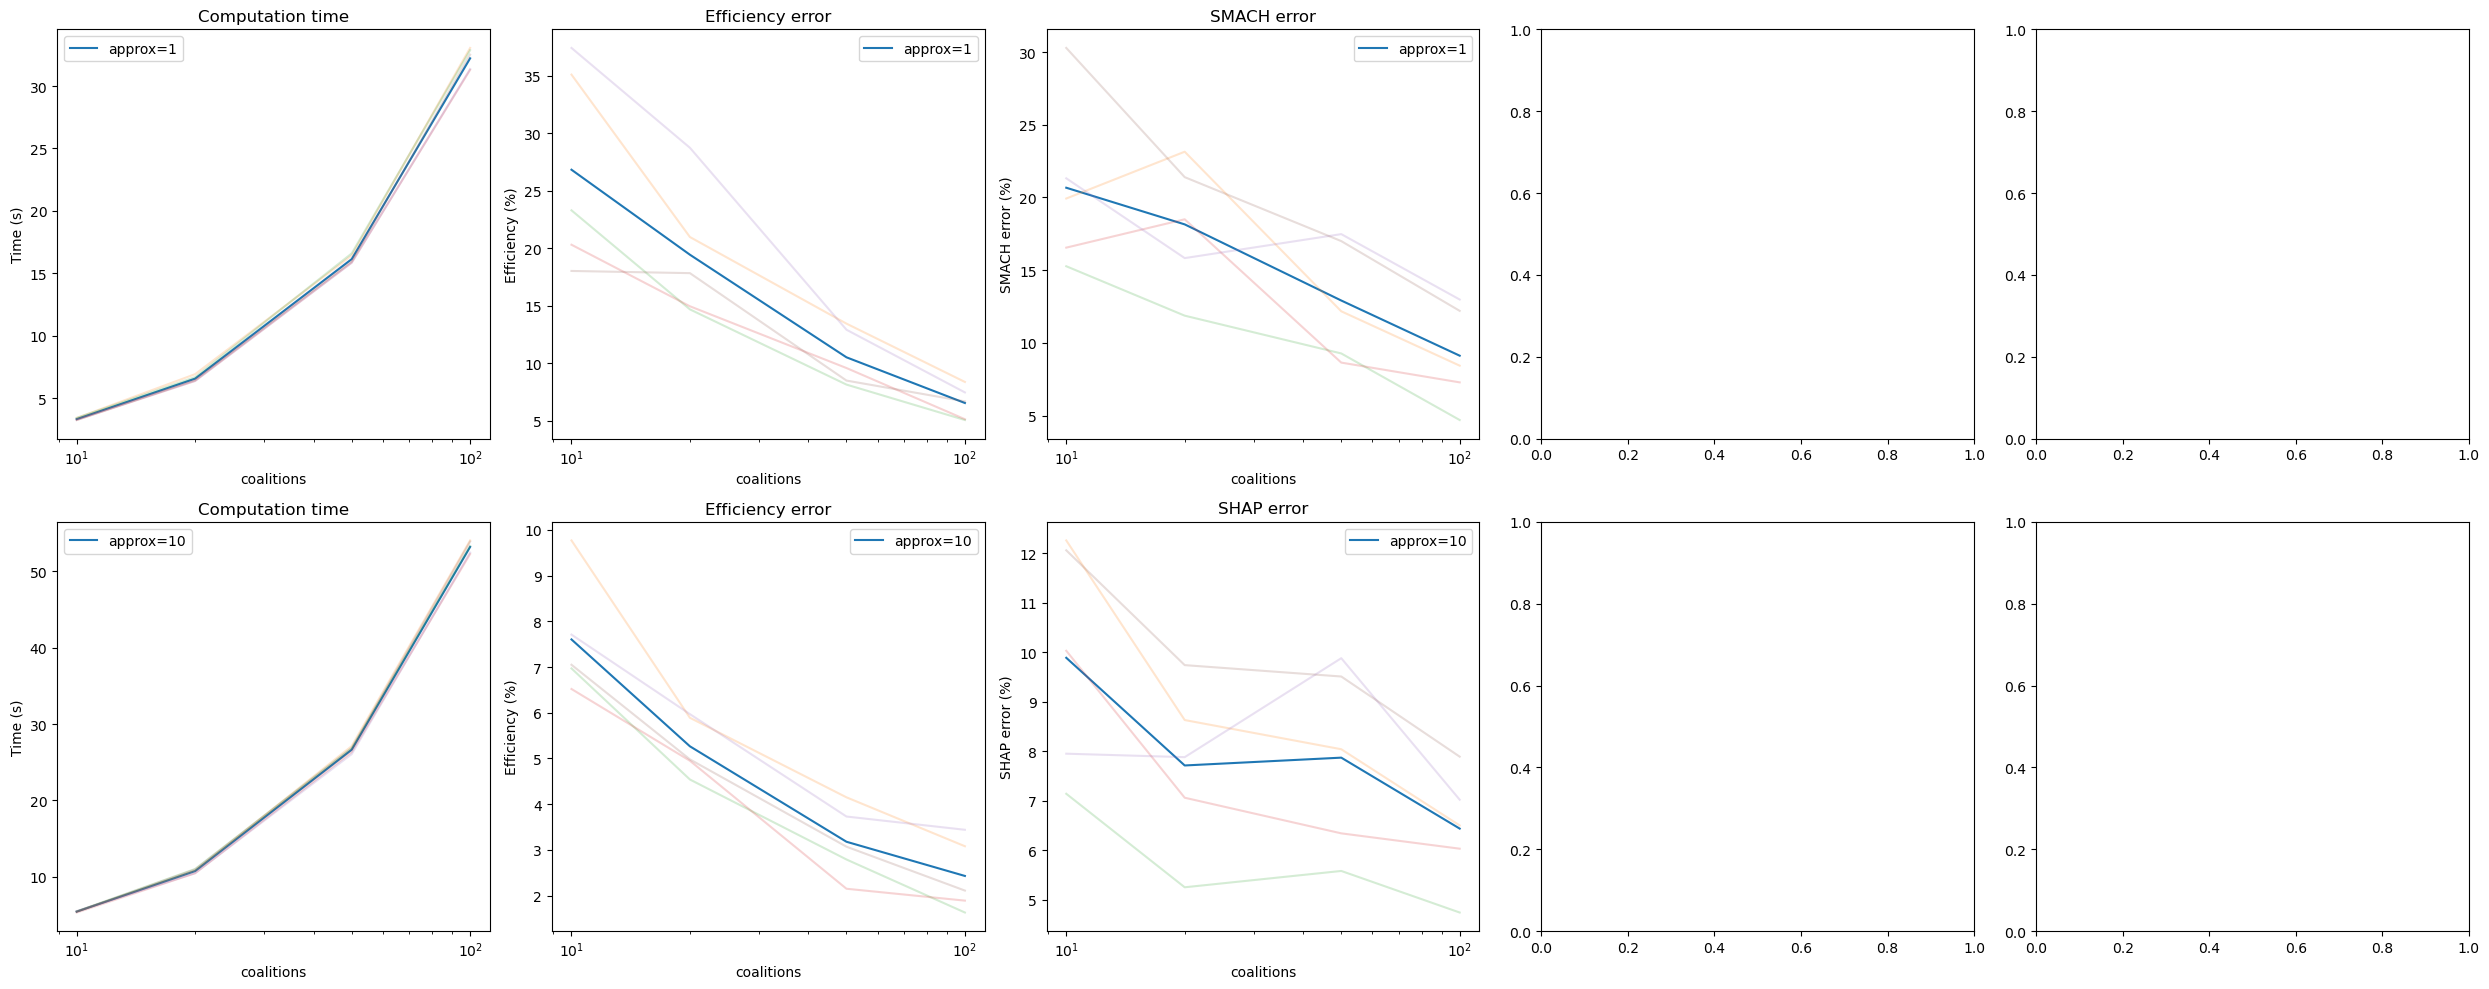

In [34]:
experiment_dict = data.open_json(expe_title,folder) #to read saved json file
analysis.plot_all(experiment_dict, param_ranges, "coalitions")

The two missing plots are for the spline errors (only computed for GAM models) and for exact error (computed when do_exact=True, which is too slow unless model is a GAM).

Other plotting functions can be used to get information on the chosen parameter value.

Experiment          Time (s)            Efficiency (%)      SMACH error (%)     GAM error (%)       SHAP error (%)      
------------------------------------------------------------------------------------------------------------------------
approx=1            32.22               6.55                9.12                nan                 nan                 
approx=10           53.22               2.43                6.44                nan                 nan                 


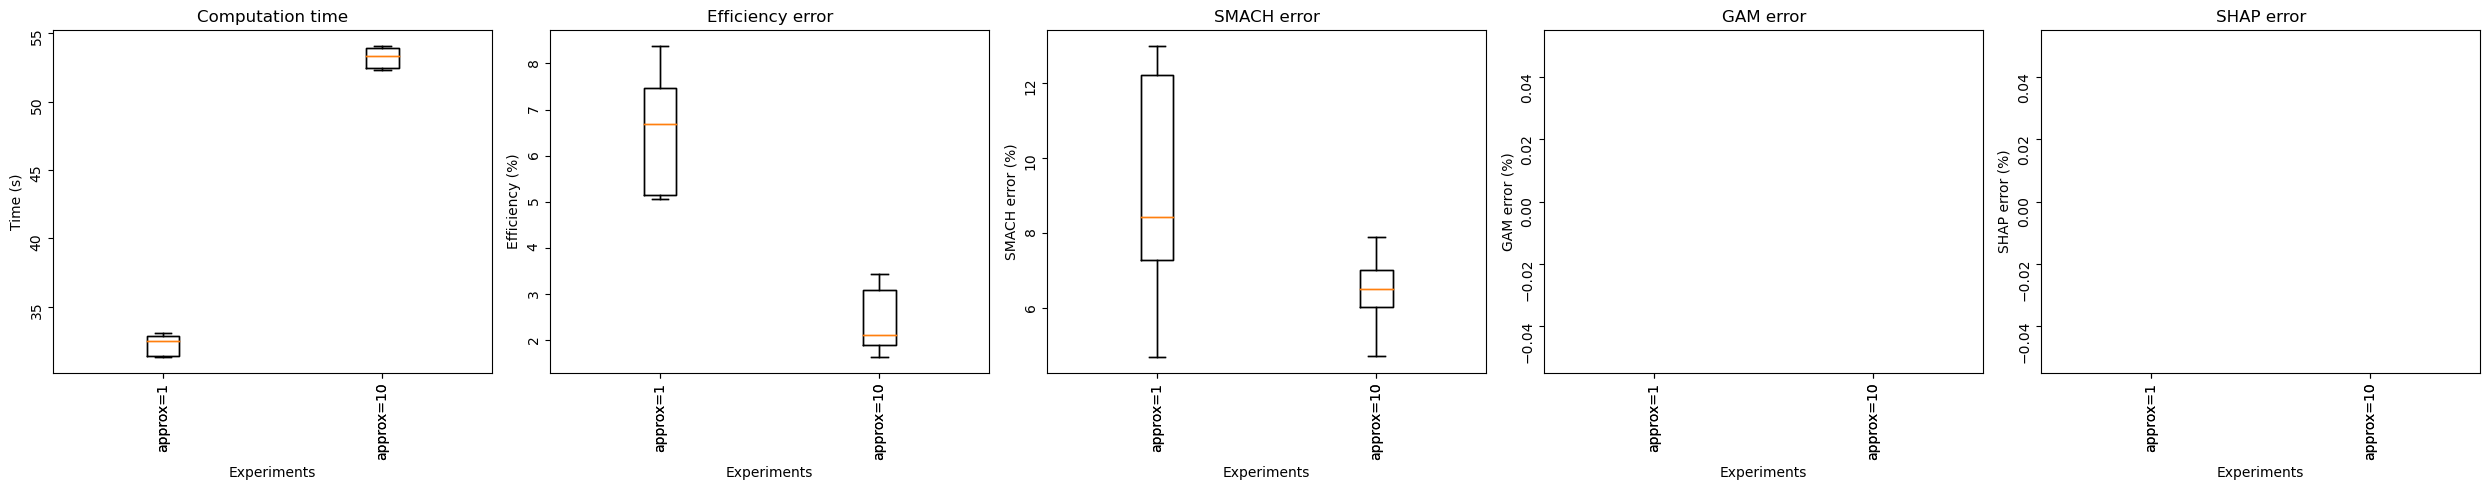

In [35]:
analysis.print_results_table(experiment_dict)
analysis.plot_boxes(experiment_dict)

### Testing different approximations

We may also set multivariate parameters to sweep. In the following experiment, we will set $n_{coalitions} \times n_{approx} = cte$ and look at the effect of reusing previously computed values (do_reuse=True)

  0%|          | 0/20 [00:00<?, ?it/s]

Repetition 1
Repetition 2
Repetition 3
Repetition 4
Repetition 5

Total computations done in 2.92 min


Degrees of freedom <= 0 for slice
invalid value encountered in true_divide
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars


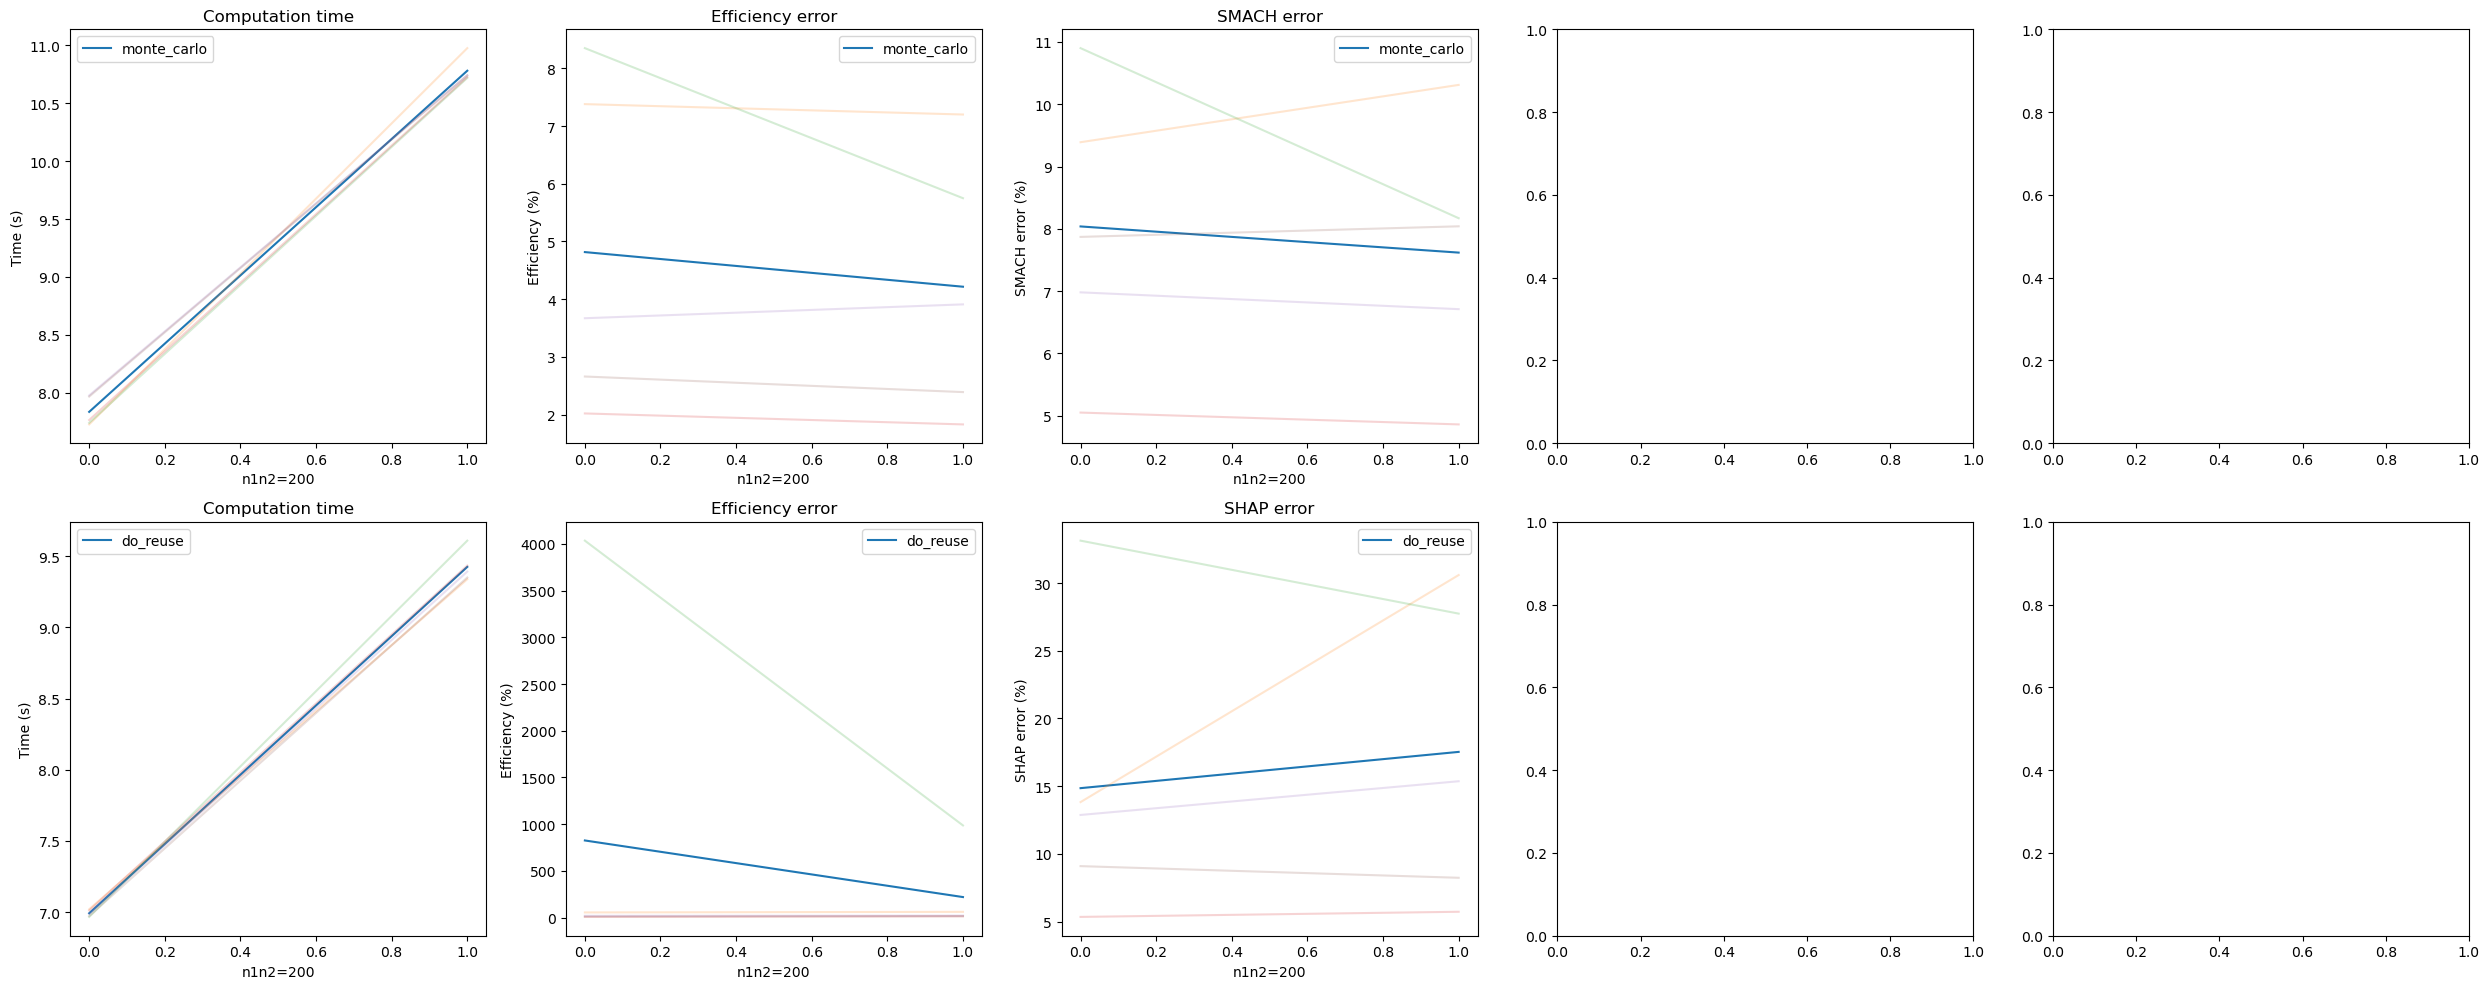

In [36]:
folder = "examples"
expe_title = "testing_fixed_n1n2"
Ndays = 48
repetitions = 5

param_ranges = {"n_coalitions":[10,20], "n_approx":[20,10]}

param_sets = {
    "monte_carlo":{"algo":"monte_carlo"},
    "do_reuse":{"algo":"monte_carlo", "do_reuse":True},

}

background_dict = {"background_y":background_y, "background_contribs":background_contribs}
X_dict = {"y":y, "true_contribs":true_contribs}

experiment_dict = analysis.do_experiment(
    background, X, param_sets, param_ranges, repetitions, col_mapping, Ndays,
    background_dict, X_dict,
    model=modelreg, expe_title=expe_title, folder=folder)

analysis.plot_all(experiment_dict, param_ranges, "n1n2=200")

We can also look at different sets of parameters without sweeping parameter values. Let's study the difference between baseline, interventional and conditional values.

  0%|          | 0/15 [00:00<?, ?it/s]

Repetition 1
Repetition 2
Repetition 3
Repetition 4
Repetition 5

Total computations done in 5.64 min


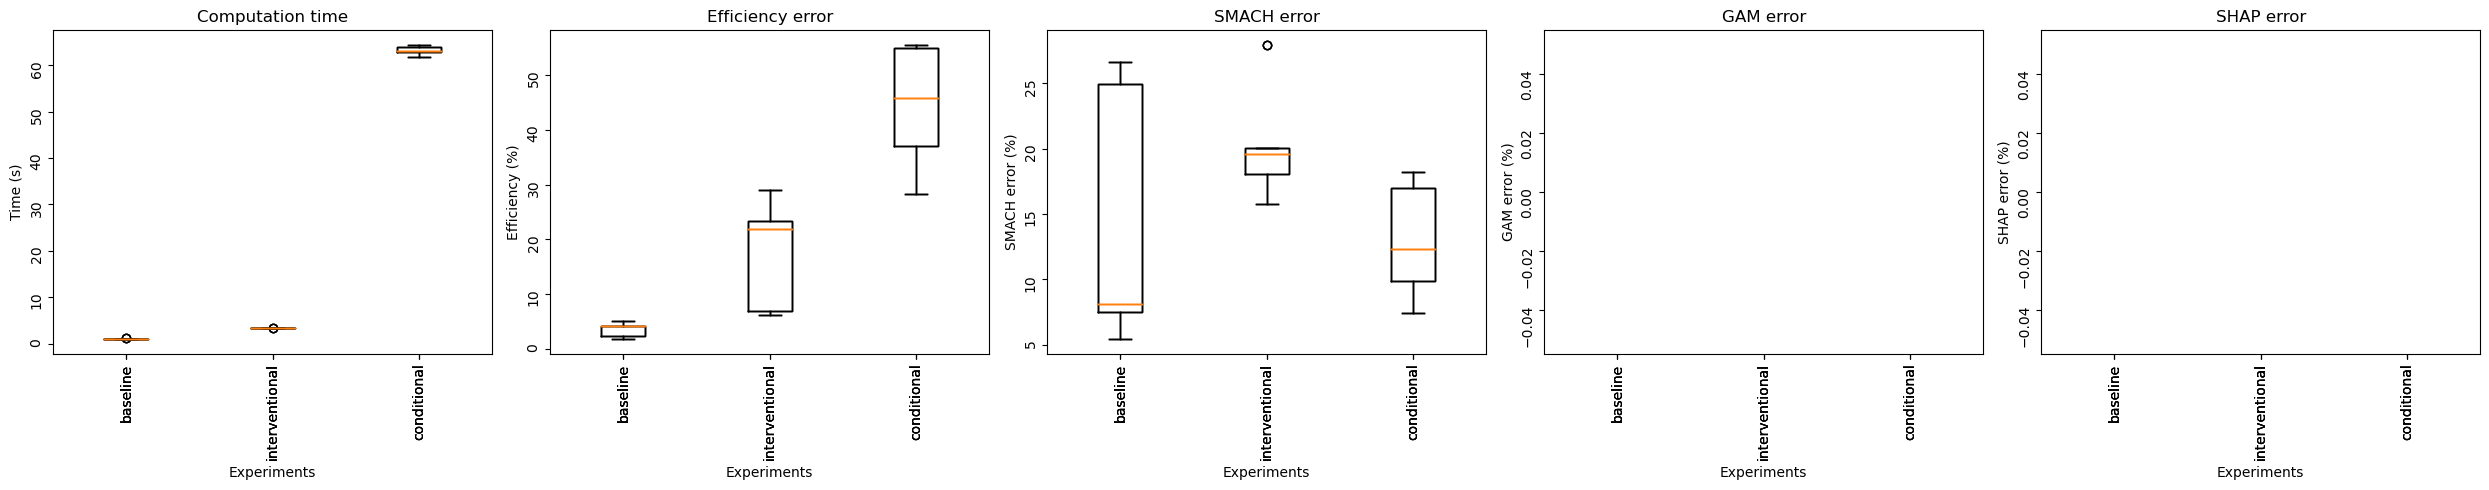

In [26]:
importlib.reload(analysis.explainers)

folder = "examples"
expe_title = "testing_conditional"
Ndays = 48
repetitions = 5

param_ranges = {}

param_sets = {
    "baseline":{"algo":"monte_carlo", "background_type":"baseline"},
    "interventional":{"algo":"monte_carlo", "background_type":"random"},
    "conditional":{"algo":"monte_carlo", "background_type":"conditional", "features_map":features_map}
}

background_dict = {"background_y":background_y, "background_contribs":background_contribs}
X_dict = {"y":y, "true_contribs":true_contribs}

experiment_dict = analysis.do_experiment(
    background, X, param_sets, param_ranges, repetitions, col_mapping, Ndays,
    background_dict, X_dict,
    model=modelreg, expe_title=expe_title, folder=folder)
analysis.plot_boxes(experiment_dict)

  0%|          | 0/15 [00:00<?, ?it/s]

Repetition 1
Repetition 2
Repetition 3
Repetition 4
Repetition 5

Total computations done in 12.99 min


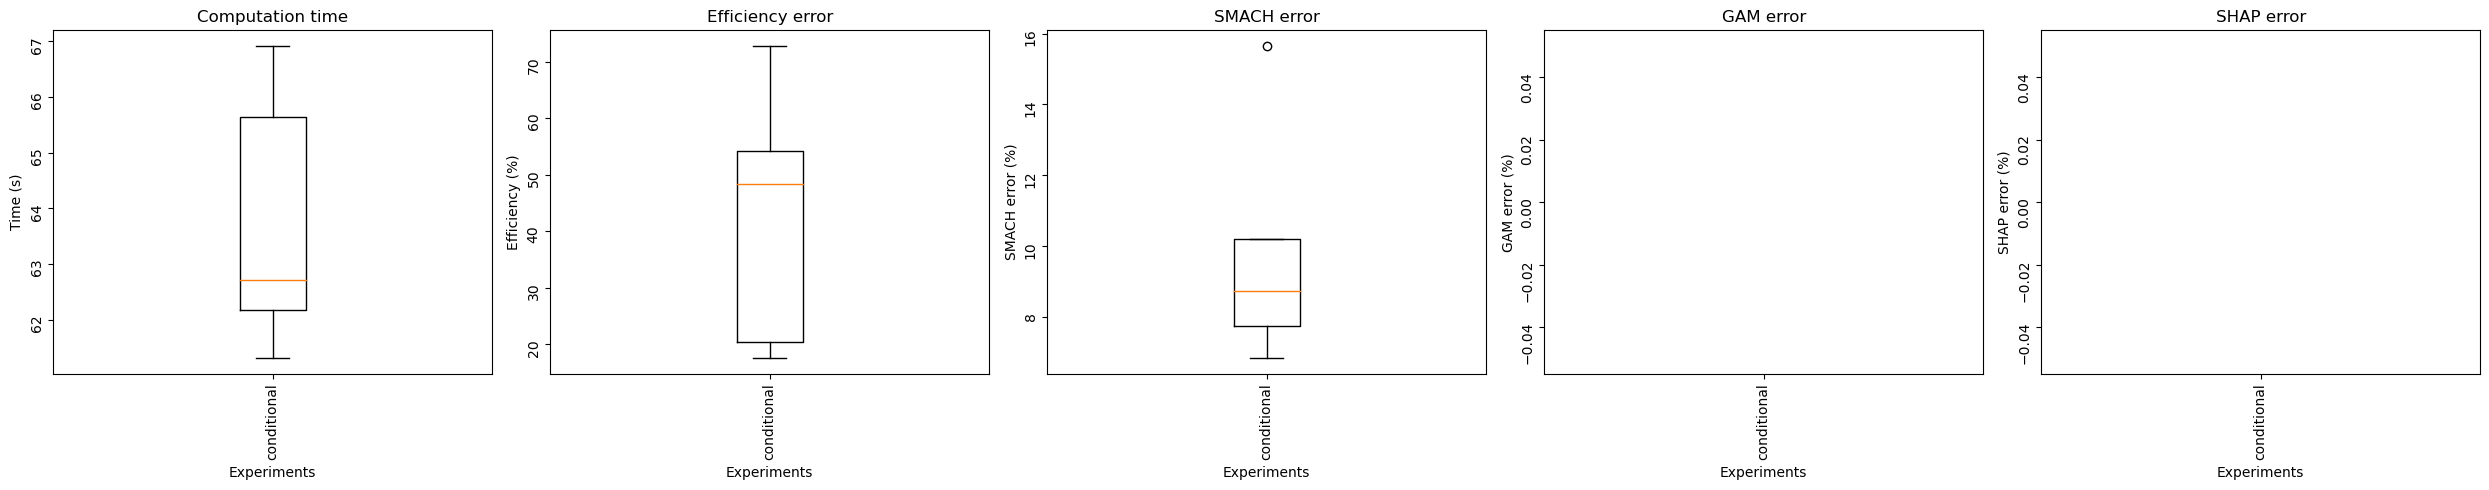

In [30]:
importlib.reload(analysis.explainers)

folder = "examples"
expe_title = "testing_intervals"
Ndays = 48
repetitions = 5

param_ranges = {"n_intervals":[1,5,10]}

param_sets = {
    "conditional":{"algo":"monte_carlo", "background_type":"conditional", "features_map":features_map}
}

background_dict = {"background_y":background_y, "background_contribs":background_contribs}
X_dict = {"y":y, "true_contribs":true_contribs}

experiment_dict = analysis.do_experiment(
    background, X, param_sets, param_ranges, repetitions, col_mapping, Ndays,
    background_dict, X_dict,
    model=modelreg, expe_title=expe_title, folder=folder)
analysis.plot_boxes(experiment_dict)

### Testing different models

  0%|          | 0/27 [00:00<?, ?it/s]

Repetition 1
loading model: gam ['temp', 'Instant', 'DayType']
loading model: gam ['temp', 'Instant', 'DayType', 'Posan']
loading model: gam ['temp', 'Instant', 'DayType', 'Posan', 'temp_liss_fort', 'temp_liss_faible', 'tempMax', 'tempMin', 'wind', 'sun', 'offset']
Repetition 2
loading model: gam ['temp', 'Instant', 'DayType']
loading model: gam ['temp', 'Instant', 'DayType', 'Posan']
loading model: gam ['temp', 'Instant', 'DayType', 'Posan', 'temp_liss_fort', 'temp_liss_faible', 'tempMax', 'tempMin', 'wind', 'sun', 'offset']
Repetition 3
loading model: gam ['temp', 'Instant', 'DayType']
loading model: gam ['temp', 'Instant', 'DayType', 'Posan']
loading model: gam ['temp', 'Instant', 'DayType', 'Posan', 'temp_liss_fort', 'temp_liss_faible', 'tempMax', 'tempMin', 'wind', 'sun', 'offset']

Total computations done in 8.67 min


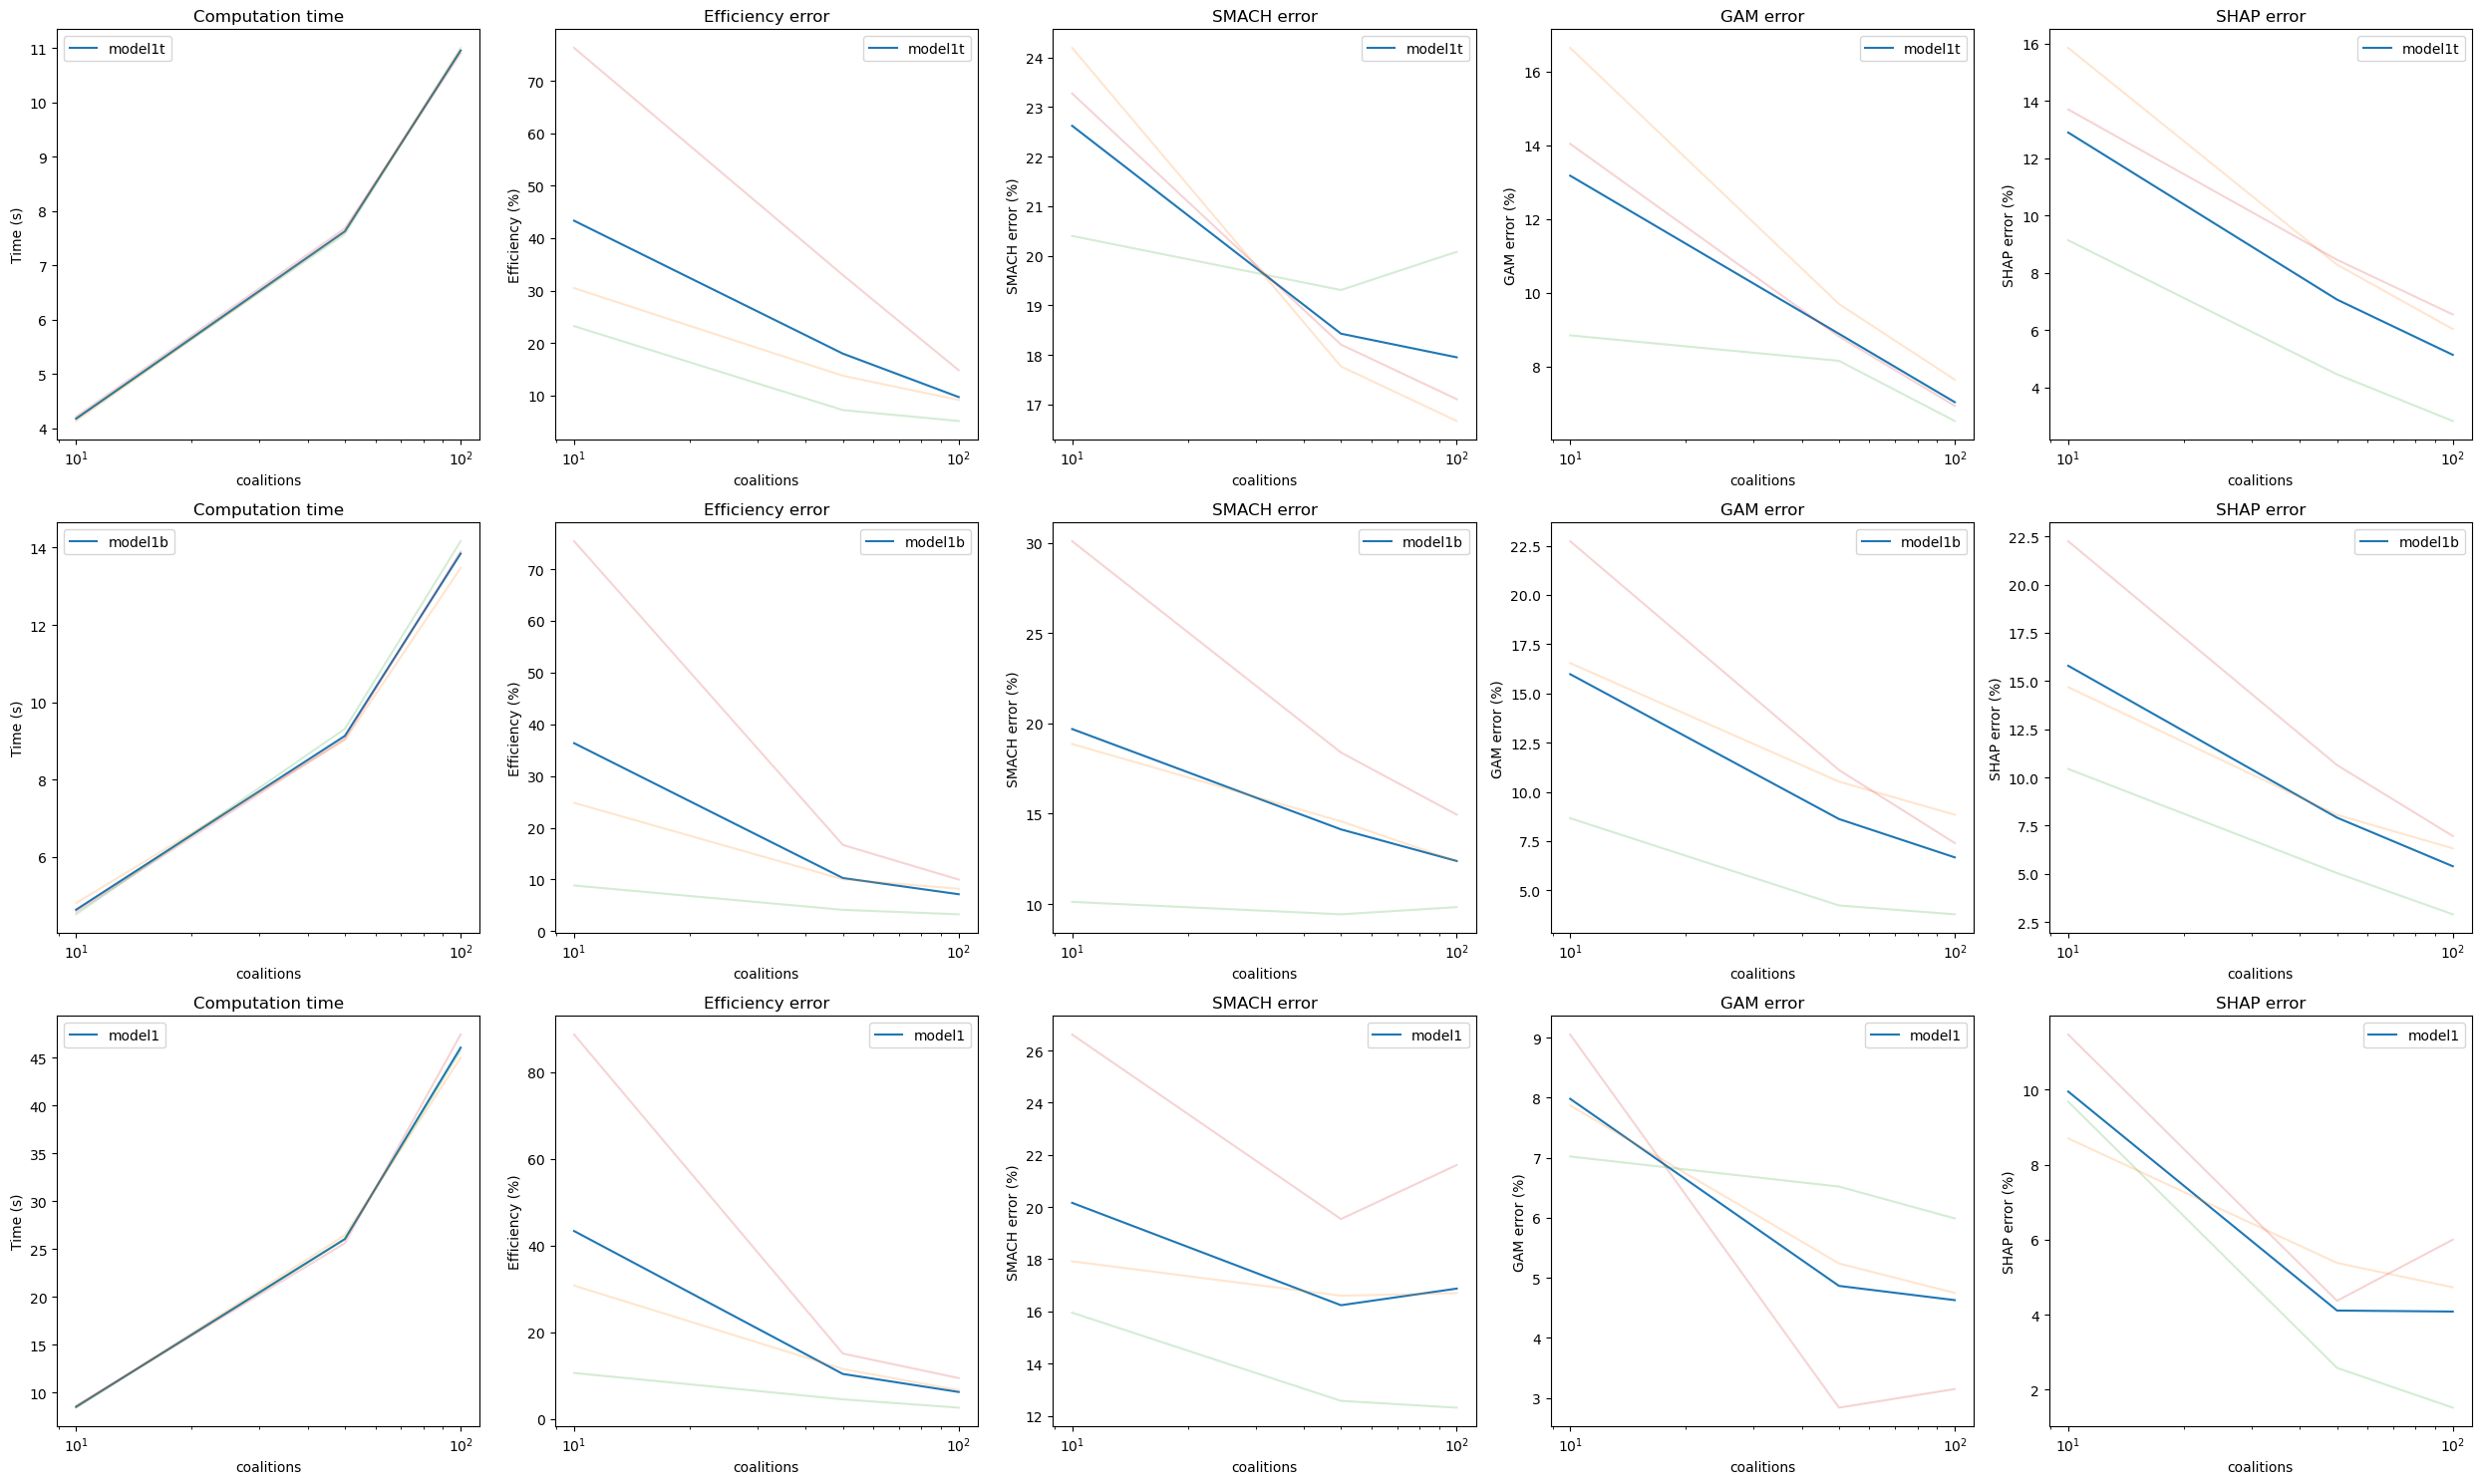

In [28]:
importlib.reload(analysis.explainers)

folder = "examples"
expe_title = "testing_gams"
Ndays = 48
repetitions = 3

param_ranges = {"n_coalitions":[10,50,100]}

param_sets = {
    "model1t":{"model":model1t, "algo":"monte_carlo"},
    "model1b":{"model":model1b, "algo":"monte_carlo"},
    "model1":{"model":model1, "algo":"monte_carlo"},
}

background_dict = {"background_y":background_y, "background_contribs":background_contribs}
X_dict = {"y":y, "true_contribs":true_contribs}

experiment_dict = analysis.do_experiment(
    background, X, param_sets, param_ranges, repetitions, col_mapping, Ndays,
    background_dict, X_dict,
    expe_title=expe_title, folder=folder,
    unique_model=False, do_exact=True)

analysis.plot_all(experiment_dict, param_ranges, "coalitions")